In [ ]:
import os
import sys
import random
import pickle

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
from scipy.spatial import distance

import torchvision
import torchvision.transforms as transforms

In [ ]:
import matplotlib.pyplot as plt

def plot_results(loss, score1, score1_title='Accuracy', score2=None, score2_title=None):
  f1 = plt.figure(1)
  ax1 = f1.add_subplot(111)
  ax1.set_title("Loss")
  ax1.set_xlabel('epochs')
  ax1.set_ylabel('loss')
  ax1.plot(loss, c='r')
  ax1.legend(['train-loss'])
  f1.show()

  f2 = plt.figure(2)
  ax2 = f2.add_subplot(111)
  ax2.set_title(score1_title)
  ax2.set_xlabel('epochs')
  ax2.set_ylabel(score1_title.lower())
  ax2.plot(score1[0], c='b')
  ax2.plot(score1[1], c='g')
  ax2.legend([f'train-{score1_title.lower()}', f'val-{score1_title.lower()}'])
  f2.show()

  if score2:
    f3= plt.figure(3)
    ax3 = f3.add_subplot(111)
    ax3.set_title(score2_title)
    ax3.set_xlabel('epochs')
    ax3.set_ylabel(score2_title.lower())
    ax3.plot(score2[0], c='b')
    ax3.plot(score2[1], c='g')
    ax3.legend([f'train-{score2_title.lower()}', f'val-{score2_title.lower()}'])
    f3.show()

# Parte 1: Arquitectura ResNet para CIFAR10

##  Arquitectura Convolucional: ResNet50



In [ ]:
class BottleneckModule(nn.Module):
  expansion: int = 4
  def __init__(self, inplanes, planes=64, stride=1, downsample = None):

    super(BottleneckModule, self).__init__()



    self.conv1 = nn.Conv2d(inplanes, planes, (1,1), stride=1)
    self.bn1 = nn.BatchNorm2d(planes) #We adopt batch normalization (BN) right after each convolution and before activation
    self.conv2 = nn.Conv2d(planes, planes, (3,3), stride=stride, padding=1)
    self.bn2 = nn.BatchNorm2d(planes)
    self.conv3 = nn.Conv2d(planes, planes * self.expansion, (1,1), stride=1)
    self.bn3 = nn.BatchNorm2d(planes * self.expansion)

    self.relu = nn.ReLU(inplace=True)

    self.downsample = downsample

  def forward(self, x):
    identity = x

    out = self.conv1(x)
    out = self.bn1(out)
    out = self.relu(out)

    out = self.conv2(out)
    out = self.bn2(out)
    out = self.relu(out)

    out = self.conv3(out)
    out = self.bn3(out)

    if self.downsample is not None:
      identity = self.downsample(x)

    out += identity
    out = self.relu(out)

    return out

In [ ]:
class ResNet50(nn.Module):
  def __init__(self, n_classes):
    super(ResNet50, self).__init__()

    self.inplanes = 64

    # Define las capas de convolución y pooling de tu arquitectura
    self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
    self.bn1 = nn.BatchNorm2d(64)
    self.relu = nn.ReLU(inplace=True)
    self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

    self.layer1 = self._make_layer(64, 3)
    self.layer2 = self._make_layer(128, 4, stride=2)
    self.layer3 = self._make_layer(256, 6, stride=2)
    self.layer4 = self._make_layer(512, 3, stride=2)
    self.avgpool = nn.AdaptiveAvgPool2d((1, 1))

    self.dropout = nn.Dropout(p=0.4)
    # Capa de salida (antes de la función de salida)
    self.fc_out = nn.Linear(512 * BottleneckModule.expansion, n_classes)

  def _make_layer(self, planes, blocks, stride=1):
    downsample = None
    if stride != 1 or self.inplanes != planes * BottleneckModule.expansion:
      downsample = nn.Sequential(
          nn.Conv2d(self.inplanes, planes * BottleneckModule.expansion, (1,1), stride),
          nn.BatchNorm2d(planes * BottleneckModule.expansion)
          )
    layers = []
    layers.append(BottleneckModule(self.inplanes, planes, stride, downsample))
    self.inplanes = planes * BottleneckModule.expansion
    for _ in range(1, blocks):
        layers.append(BottleneckModule(self.inplanes, planes))

    return nn.Sequential(*layers)

  def forward(self, x):
    # Computa las representaciones internas de la red
    x = self.conv1(x)
    x = self.bn1(x)
    x = self.relu(x)
    x = self.maxpool(x)
    x = self.dropout(x)

    x = self.layer1(x)
    x = self.layer2(x)
    x = self.layer3(x)
    x = self.layer4(x)
    h = x

    x = self.avgpool(x)

    x = self.dropout(x)

    x = torch.flatten(x, 1)

    logits = self.fc_out(x)

    # En hidden debes devolver alguna de las capas oculta de la red
    return {'hidden': h, 'logits': logits}

In [ ]:
class ResNet101(nn.Module):
  def __init__(self, n_classes):
    super(ResNet50, self).__init__()

    self.inplanes = 64

    # Define las capas de convolución y pooling de tu arquitectura
    self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
    self.bn1 = nn.BatchNorm2d(64)
    self.relu = nn.ReLU(inplace=True)
    self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

    self.layer1 = self._make_layer(64, 3)
    self.layer2 = self._make_layer(128, 4, stride=2)
    self.layer3 = self._make_layer(256, 23, stride=2)
    self.layer4 = self._make_layer(512, 3, stride=2)
    self.avgpool = nn.AdaptiveAvgPool2d((1, 1))

    self.dropout = nn.Dropout(p=0.4)
    # Capa de salida (antes de la función de salida)
    self.fc_out = nn.Linear(512 * BottleneckModule.expansion, n_classes)

  def _make_layer(self, planes, blocks, stride=1):
    downsample = None
    if stride != 1 or self.inplanes != planes * BottleneckModule.expansion:
      downsample = nn.Sequential(
          nn.Conv2d(self.inplanes, planes * BottleneckModule.expansion, (1,1), stride),
          nn.BatchNorm2d(planes * BottleneckModule.expansion)
          )
    layers = []
    layers.append(BottleneckModule(self.inplanes, planes, stride, downsample))
    self.inplanes = planes * BottleneckModule.expansion
    for _ in range(1, blocks):
        layers.append(BottleneckModule(self.inplanes, planes))

    return nn.Sequential(*layers)

  def forward(self, x):
    # Computa las representaciones internas de la red
    x = self.conv1(x)
    x = self.bn1(x)
    x = self.relu(x)
    x = self.maxpool(x)
    x = self.dropout(x)

    x = self.layer1(x)
    x = self.layer2(x)
    x = self.layer3(x)
    x = self.layer4(x)
    h = x

    x = self.avgpool(x)

    x = self.dropout(x)

    x = torch.flatten(x, 1)

    logits = self.fc_out(x)

    # En hidden debes devolver alguna de las capas oculta de la red
    return {'hidden': h, 'logits': logits}

## 1c.2) Arquitectura Convolucional: ResNet18



In [ ]:
class BuildingBlock(nn.Module):
  expansion: int = 1
  def __init__(self, inplanes, planes=64, stride=1, downsample = None):

    super(BuildingBlock, self).__init__()

    self.conv1 = nn.Conv2d(inplanes, planes, (3,3), stride=stride, padding=1)
    self.bn1 = nn.BatchNorm2d(planes)
    self.conv2 = nn.Conv2d(planes, planes, (3,3), stride=stride, padding=1)
    self.bn2 = nn.BatchNorm2d(planes)

    self.relu = nn.ReLU(inplace=True)

    self.downsample = downsample

  def forward(self, x):
    identity = x

    out = self.conv1(x)
    out = self.bn1(out)
    out = self.relu(out)

    out = self.conv2(out)
    out = self.bn2(out)

    if self.downsample is not None:
      identity = self.downsample(x)
    out += identity
    out = self.relu(out)

    return out

In [ ]:
# Acá el código para tu primera arquitectura

class ResNet18(nn.Module):
  def __init__(self, n_classes):
    super(ResNet18, self).__init__()

    self.inplanes = 64

    # Define las capas de convolución y pooling de tu arquitectura
    self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
    self.bn1 = nn.BatchNorm2d(64)
    self.relu = nn.ReLU(inplace=True)
    self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

    self.layer1 = self._make_layer(64, 2)
    self.layer2 = self._make_layer(128, 2, stride=1)
    self.layer3 = self._make_layer(256, 2, stride=1)
    self.layer4 = self._make_layer(512, 2, stride=1)
    self.avgpool = nn.AdaptiveAvgPool2d((1, 1))

    self.dropout = nn.Dropout(p=0.5)
    # Capa de salida (antes de la función de salida)
    self.fc_out = nn.Linear(512 * BuildingBlock.expansion, n_classes)

  def _make_layer(self, planes, blocks, stride=1):
    downsample = None
    if stride != 1 or self.inplanes != planes * BuildingBlock.expansion:
      downsample = nn.Sequential(
          nn.Conv2d(self.inplanes, planes * BuildingBlock.expansion, (1,1), stride),
          nn.BatchNorm2d(planes * BuildingBlock.expansion)
          )
    layers = []
    layers.append(BuildingBlock(self.inplanes, planes, stride, downsample))
    self.inplanes = planes * BuildingBlock.expansion
    for _ in range(1, blocks):
        layers.append(BuildingBlock(self.inplanes, planes))

    return nn.Sequential(*layers)

  def forward(self, x):
    # Computa las representaciones internas de la red
    x = self.conv1(x)
    x = self.bn1(x)
    x = self.relu(x)
    x = self.maxpool(x)

    x = self.layer1(x)
    x = self.layer2(x)
    x = self.layer3(x)
    x = self.layer4(x)

    x = self.avgpool(x)
    hidden = x

    x = self.dropout(x)

    x = torch.flatten(x, 1)

    logits = self.fc_out(x)

    # En hidden debes devolver alguna de las capas oculta de la red
    return {'hidden': hidden, 'logits': logits}

## 1d) Clasificación de Imágenes en CIFAR10

In [ ]:
##############################################################################
# Todo este código sirve para descargar, preprocesar y dejar los datos
# listos para usar después. Después de ejecutar las celdas tendrás los datos
# trainset, trainloader y similar para test.
##############################################################################

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


ResNet50 en CIFAR10
Val_Acc = 60%

In [ ]:
# Definamos algunos hiper-parámetros
BATCH_SIZE = 128
LR = 0.1
EPOCHS = 40
REPORTS_EVERY = 1

net = ResNet50(n_classes=len(classes)) # tu modelo de CNN (para clasificar en 10 clases)
optimizer = optim.SGD(net.parameters(), lr=LR, weight_decay=0.0001, momentum=0.9) # optimizador, e.g., optim.SGD, optim.Adam, ...
criterion = nn.CrossEntropyLoss() # función de pérdida
scheduler = StepLR(optimizer, step_size=8, gamma=0.1) # (opcional) optim.lr_scheduler proporciona varios métodos para ajustar el lr según el número de épocas

train_loader = DataLoader(trainset, batch_size=BATCH_SIZE,
                          shuffle=True, num_workers=2)
test_loader = DataLoader(testset, batch_size=BATCH_SIZE,
                         shuffle=False, num_workers=2)

train_loss, acc = train_for_classification(net, train_loader,
                                           test_loader, optimizer,
                                           criterion, lr_scheduler=scheduler,
                                           epochs=EPOCHS, reports_every=REPORTS_EVERY)

plot_results(train_loss, acc)

### ResNet18 en CIFAR10
Val_Acc = 82% (No DropOut)

Epoch:1(50000/50000), lr:0.1000000, Loss:1.83690, Train Acc:35.1%, Validating..., Val Acc:42.84%, Avg-Time:19.204s.
Epoch:2(50000/50000), lr:0.1000000, Loss:1.31398, Train Acc:51.7%, Validating..., Val Acc:52.94%, Avg-Time:19.271s.
Epoch:3(50000/50000), lr:0.1000000, Loss:1.09084, Train Acc:60.6%, Validating..., Val Acc:61.12%, Avg-Time:19.331s.
Epoch:4(50000/50000), lr:0.1000000, Loss:0.93097, Train Acc:66.6%, Validating..., Val Acc:64.63%, Avg-Time:19.342s.
Epoch:5(50000/50000), lr:0.1000000, Loss:0.81167, Train Acc:71.6%, Validating..., Val Acc:71.02%, Avg-Time:19.317s.
Epoch:6(50000/50000), lr:0.1000000, Loss:0.71877, Train Acc:74.7%, Validating..., Val Acc:72.32%, Avg-Time:19.327s.
Epoch:7(50000/50000), lr:0.1000000, Loss:0.64113, Train Acc:77.4%, Validating..., Val Acc:74.71%, Avg-Time:19.301s.
Epoch:8(50000/50000), lr:0.1000000, Loss:0.57650, Train Acc:80.0%, Validating..., Val Acc:74.51%, Avg-Time:19.296s.
Epoch:9(50000/50000), lr:0.1000000, Loss:0.53476, Train Acc:81.3%, Valid

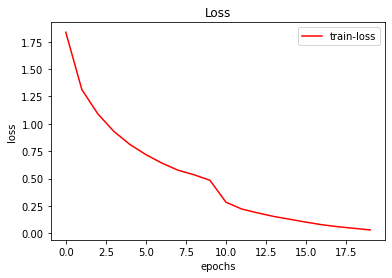

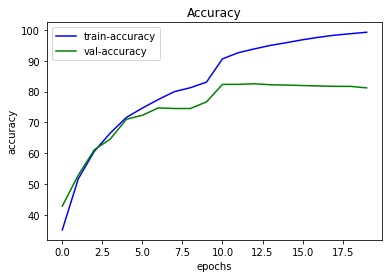

In [ ]:
# Definamos algunos hiper-parámetros
BATCH_SIZE = 128
LR = 0.1
EPOCHS = 20
REPORTS_EVERY = 1

net = ResNet18(n_classes=len(classes)) # tu modelo de CNN (para clasificar en 10 clases)
optimizer = optim.SGD(net.parameters(), lr=LR, weight_decay=0.0001, momentum=0.9) # optimizador, e.g., optim.SGD, optim.Adam, ...
criterion = nn.CrossEntropyLoss() # función de pérdida
scheduler = StepLR(optimizer, step_size=10, gamma=0.1) # (opcional) optim.lr_scheduler proporciona varios métodos para ajustar el lr según el número de épocas

train_loader = DataLoader(trainset, batch_size=BATCH_SIZE,
                          shuffle=True, num_workers=2)
test_loader = DataLoader(testset, batch_size=BATCH_SIZE,
                         shuffle=False, num_workers=2)

train_loss, acc = train_for_classification(net, train_loader,
                                           test_loader, optimizer,
                                           criterion, lr_scheduler=scheduler,
                                           epochs=EPOCHS, reports_every=REPORTS_EVERY)

plot_results(train_loss, acc)

### ResNet18 en CIFAR10
Val_Acc = 82% (1xDropOut = 0.4)

Epoch:1(50000/50000), lr:0.1000000, Loss:1.88541, Train Acc:32.2%, Validating..., Val Acc:42.50%, Avg-Time:19.355s.
Epoch:2(50000/50000), lr:0.1000000, Loss:1.38921, Train Acc:49.2%, Validating..., Val Acc:53.76%, Avg-Time:19.303s.
Epoch:3(50000/50000), lr:0.1000000, Loss:1.15914, Train Acc:58.3%, Validating..., Val Acc:58.13%, Avg-Time:19.224s.
Epoch:4(50000/50000), lr:0.1000000, Loss:0.98643, Train Acc:65.0%, Validating..., Val Acc:65.87%, Avg-Time:19.189s.
Epoch:5(50000/50000), lr:0.1000000, Loss:0.84266, Train Acc:70.3%, Validating..., Val Acc:69.74%, Avg-Time:19.197s.
Epoch:6(50000/50000), lr:0.1000000, Loss:0.74183, Train Acc:74.4%, Validating..., Val Acc:73.01%, Avg-Time:19.201s.
Epoch:7(50000/50000), lr:0.1000000, Loss:0.65831, Train Acc:77.1%, Validating..., Val Acc:73.03%, Avg-Time:19.204s.
Epoch:8(50000/50000), lr:0.1000000, Loss:0.58722, Train Acc:79.5%, Validating..., Val Acc:72.40%, Avg-Time:19.220s.
Epoch:9(50000/50000), lr:0.1000000, Loss:0.52545, Train Acc:81.7%, Valid

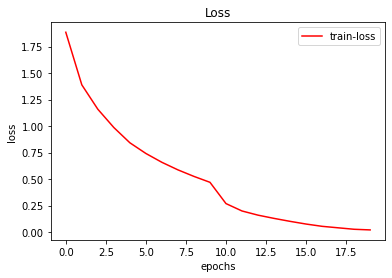

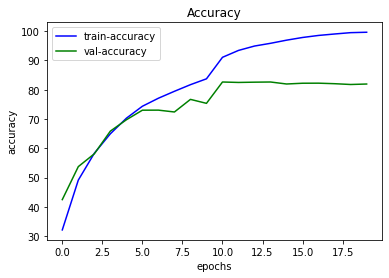

In [ ]:
BATCH_SIZE = 128
LR = 0.1
EPOCHS = 20
REPORTS_EVERY = 1

net = ResNet18(n_classes=len(classes)) # tu modelo de CNN (para clasificar en 10 clases)
optimizer = optim.SGD(net.parameters(), lr=LR, weight_decay=0.0001, momentum=0.9) # optimizador, e.g., optim.SGD, optim.Adam, ...
criterion = nn.CrossEntropyLoss() # función de pérdida
scheduler = StepLR(optimizer, step_size=10, gamma=0.1) # (opcional) optim.lr_scheduler proporciona varios métodos para ajustar el lr según el número de épocas

train_loader = DataLoader(trainset, batch_size=BATCH_SIZE,
                          shuffle=True, num_workers=2)
test_loader = DataLoader(testset, batch_size=BATCH_SIZE,
                         shuffle=False, num_workers=2)

train_loss, acc = train_for_classification(net, train_loader,
                                           test_loader, optimizer,
                                           criterion, lr_scheduler=scheduler,
                                           epochs=EPOCHS, reports_every=REPORTS_EVERY)

plot_results(train_loss, acc)

ResNet18 Funciona mejor que ResNet50 (hay menos overfit), esto tieen sentido ya que el dataset y las clases es muy pequeño para trabajar con tantas capas.

In [ ]:
# Test
x, y = list(test_loader)[0]
net.cpu()
net.eval()
y_pred = net(x)['logits'].max(dim=1)[1]

# Veamos como se comporta el modelo
print("Correct Test!" if (y==y_pred).sum()/len(x) >= .75 else "Failed Test! [acc]")

Correct Test!


##  CIFAR100

In [ ]:
##############################################################################
# Toda esta parte es similar a la anterior pero para CIFAR100.
##############################################################################

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR100(root='./data/cifar100', train=True,
                                         download=True, transform=transform)

testset = torchvision.datasets.CIFAR100(root='./data/cifar100', train=False,
                                        download=True, transform=transform)

In [ ]:
# Definamos algunos hiper-parámetros
BATCH_SIZE = ...
LR = ...
EPOCHS = ...
REPORTS_EVERY = 1

net = ... # tu modelo de CNN (para clasificar en 100 clases)
optimizer = ... # optimizador, e.g., optim.SGD, optim.Adam, ...
criterion = nn.CrossEntropyLoss() # función de pérdida
scheduler = ... # (opcional) optim.lr_scheduler proporciona varios métodos para ajustar el lr según el número de épocas

train_loader = DataLoader(trainset, batch_size=BATCH_SIZE,
                          shuffle=True, num_workers=2)
test_loader = DataLoader(testset, batch_size=4*BATCH_SIZE,
                         shuffle=False, num_workers=2)

train_loss, acc = train_for_classification(net, train_loader,
                                           test_loader, optimizer,
                                           criterion, lr_scheduler=scheduler,
                                           epochs=EPOCHS, reports_every=REPORTS_EVERY)

plot_results(train_loss, acc)